# Exploratory Data Analysis & Preprocessing

In [63]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [64]:
import os
import sys

# Add the src directory to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [65]:
import pandas as pd

pd.set_option('display.max_columns', None)

# suppress debugging warnings
import warnings
warnings.filterwarnings('ignore')

In [66]:
FOLDS = 3

## Data Preprocessing

### Load the dataset

In [67]:
from IPython.display import display
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

from src import preprocessing

if "df_backup" not in globals():
    # takes 2-4min
    df = preprocessing.load_data()
    df_backup = df.copy()
else:
    df = df_backup.copy()  # type: ignore

### Brief Inspection

In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260701 entries, 0 to 2260700
Columns: 151 entries, id to settlement_term
dtypes: float64(113), object(38)
memory usage: 2.5+ GB


In [69]:
with pd.option_context('display.max_rows', None):
    display(df.dtypes)

id                                             object
member_id                                     float64
loan_amnt                                     float64
funded_amnt                                   float64
funded_amnt_inv                               float64
term                                           object
int_rate                                      float64
installment                                   float64
grade                                          object
sub_grade                                      object
emp_title                                      object
emp_length                                     object
home_ownership                                 object
annual_inc                                    float64
verification_status                            object
issue_d                                        object
loan_status                                    object
pymnt_plan                                     object
url                         

In [70]:
# View first few rows
print("First few rows:")
display(df.head())

# Check for missing values
print("\nMissing values:")
display(df.isnull().sum().where(lambda x: x > 0).dropna())

# Summary statistics
print("\nSummary statistics:")
display(df.describe(include='all'))

First few rows:


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,leadman,10+ years,MORTGAGE,55000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,190xx,PA,5.91,0.0,Aug-2003,675.0,679.0,1.0,30.0,NaN,7.0,0.0,2765.0,29.7,13.0,w,0.00,0.00,4421.723917,4421.72,3600.00,821.72,0.0,0.0,0.0,Jan-2019,122.67,NaN,Mar-2019,564.0,560.0,0.0,30.0,1.0,Individual,NaN,NaN,NaN,0.0,722.0,144904.0,2.0,2.0,0.0,1.0,21.0,4981.0,36.0,3.0,3.0,722.0,34.0,9300.0,3.0,1.0,4.0,4.0,20701.0,1506.0,37.2,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,69.0,4.0,69.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,Engineer,10+ years,MORTGAGE,65000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,Business,577xx,SD,16.06,1.0,Dec-1999,715.0,719.0,4.0,6.0,NaN,22.0,0.0,21470.0,19.2,38.0,w,0.00,0.00,25679.660000,25679.66,24700.00,979.66,0.0,0.0,0.0,Jun-2016,926.35,NaN,Mar-2019,699.0,695.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,204396.0,1.0,1.0,0.0,1.0,19.0,18005.0,73.0,2.0,3.0,6472.0,29.0,111800.0,0.0,0.0,6.0,4.0,9733.0,57830.0,27.1,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,NaN,0.0,6.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,NaN,NaN,NaN,NaN,NaN,N


Missing values:


member_id                2260701.0
loan_amnt                     33.0
funded_amnt                   33.0
funded_amnt_inv               33.0
term                          33.0
                           ...    
settlement_status        2226455.0
settlement_date          2226455.0
settlement_amount        2226455.0
settlement_percentage    2226455.0
settlement_term          2226455.0
Length: 150, dtype: float64


Summary statistics:


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
count,2260701,0.0,2.260668e+06,2.260668e+06,2.260668e+06,2260668,2.260668e+06,2.260668e+06,2260668,2260668,2093699,2113761,2260668,2.260664e+06,2260668,2260668,2260668,2260668,2260668,126065,2260668,2237342,2260667,2260668,2.258957e+06,2.260639e+06,2260639,2.260668e+06,2.260668e+06,2.260638e+06,1.102166e+06,359156.000000,2.260639e+06,2.260639e+06,2.260668e+06,2.258866e+06,2.260639e+06,2260668,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,2258241,2.260668e+06,915358,2260596,2.260668e+06,2.260668e+06,2.260523e+06,580775.000000,2260668.0,2260668,1.207100e+05,120706.000000,115730,2.260639e+06,2.190392e+06,2.190392e+06,1.394538e+06,1.394539e+06,1.394539e+06,1.394539e+06,1.350744e+06,1.394539e+06,1.191818e+06,1.394539e+06,1.394539e+06,1.394539e+06,1.394320e+06,2.190392e+06,1.394539e+06,1.394538e+06,1.394538e+06,2.210638e+06,2.190322e+06,2.185733e+06,2.184597e+06,2.260523e+06,2.260639e+06,2.121597e+06,2.190391e+06,2.190391e+06,2.190392e+06,2.210638e+06,2.187256e+06,519701.000000,1.965233e+06,740359.000000,2.190392e+06,2.190392e+06,2.190392e+06,2.202078e+06,2.190392e+06,2.190392e+06,2.190392e+06,2.190391e+06,2.190392e+06,2.202078e+06,2.107011e+06,2.190392e+06,2.190392e+06,2.190392e+06,2.190237e+06,2.185289e+06,2.259303e+06,2.260563e+06,2.190392e+06,2.210638e+06,2.210638e+06,2.190392e+06,1.080200e+05,108021.000000,108021.000000,108021,108021.000000,108021.000000,108021.000000,106184.000000,108021.000000,108021.000000,108021.000000,108021.000000,35942.000000,2260668,10917,10917,10917,10917.0

### Data Cleaning

In [71]:
# Remove features that are independent of the target variable
INDEP_COLS = [
    'emp_title', 
    'id', 
    'member_id', 
    'policy_code', 
    'title', 
    'url',
]

# Remove columns that could cause data leakage
LEAKAGE_COLS = [
    'collection_recovery_fee', 
    'debt_settlement_flag_date',
    'debt_settlement_flag', 
    'deferral_term',
    'disbursement_method', 
    'funded_amnt_inv',
    'funded_amnt', 
    'hardship_amount',
    'hardship_dpd',
    'hardship_end_date',
    'hardship_flag',
    'hardship_flag',
    'hardship_length',
    'hardship_length',
    'hardship_loan_status',
    'hardship_reason',
    'hardship_start_date',
    'hardship_status',
    'hardship_type',
    'initial_list_status',
    'issue_d',
    'last_credit_pull_d', 
    'last_fico_range_high',
    'last_fico_range_low', 
    'last_pymnt_amnt',
    'last_pymnt_d', 
    'next_pymnt_d',
    'out_prncp_inv', 
    'out_prncp',
    'payment_plan_start_date',
    'pymnt_plan', 
    'recoveries', 
    'settlement_amount',
    'settlement_date',
    'settlement_percentage',
    'settlement_status',
    'settlement_term',
    'total_pymnt_inv', 
    'total_pymnt', 
    'total_rec_int',
    'total_rec_late_fee', 
    'total_rec_prncp', 
]

cols_to_drop = INDEP_COLS + LEAKAGE_COLS
df = preprocessing.drop_cols(df, cols=cols_to_drop)

In [72]:
# Remove features with too many missing values
df = preprocessing.drop_sparse_cols(df, missing_rate=0.5)

In [73]:
# Convert date columns to unix timestamps
date_cols = ['earliest_cr_line']
df = preprocessing.convert_dates(df, cols=date_cols)

In [74]:
# handle emp_length
from src.preprocessing import extract_digits

df[df['emp_length'] == '< 1 year'] = 0
df = extract_digits(df, cols=['emp_length'])

In [75]:
# Extract digits from string values
df = preprocessing.extract_digits(df, cols=['term', 'zip_code'])

In [76]:
# Label Encoding for ordinal categorical variables
from src.feature_engineering import index_categories

grades = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
df = index_categories(df, 'grade', categories=grades)

sub_grades = [f'{g}{s}' for g in grades for s in range(1, 6)]
df = index_categories(df, 'sub_grade', categories=sub_grades)

In [77]:
# Impute missing values
df = preprocessing.impute_missing_values(df)

In [78]:
df.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,collections_12_mths_ex_med,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,3600.0,36.0,13.99,123.03,2.0,13.0,10.0,MORTGAGE,55000.0,Not Verified,Fully Paid,debt_consolidation,190.0,PA,5.91,0.0,1.059696e+09,675.0,679.0,1.0,7.0,0.0,2765.0,29.7,13.0,0.0,Individual,0.0,722.0,144904.0,2.0,2.0,0.0,1.0,21.0,4981.0,36.0,3.0,3.0,722.0,34.0,9300.0,3.0,1.0,4.0,4.0,20701.0,1506.0,37.2,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,4.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0
1,24700.0,36.0,11.99,820.28,2.0,10.0,10.0,MORTGAGE,65000.0,Not Verified,Fully Paid,small_business,577.0,SD,16.06,1.0,9.440064e+08,715.0,719.0,4.0,22.0,0.0,21470.0,19.2,38.0,0.0,Individual,0.0,0.0,204396.0,1.0,1.0,0.0,1.0,19.0,18005.0,73.0,2.0,3.0,6472.0,29.0,111800.0,0.0,0.0,6.0,4.0,9733.0,57830.0,27.1,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,0.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0
2,20000.0,60.0,10.78,432.66,1.0,8.0,10.0,MORTGAGE,63000.0,Not Verified,Fully Paid,home_improvement,605.0,IL,10.78,0.0,9.650880e+08,695.0,699.0,0.0,6.0,0.0,7869.0,56.2,18.0,0.0,Joint App,0.0,0.0,189699.0,0.0,1.0,0.0,4.0,19.0,10827.0,73.0,0.0,2.0,2081.0,65.0,14000.0,2.0,5.0,1.0,6.0,31617.0,2737.0,55.9,0.0,0.0,125.0,184.0,14.0,14.0,5.0,101.0,10.0,0.0,2.0,3.0,2.0,4.0,6.0,4.0,7.0,3.0,6.0,0.0,0.0,0.0,0.0,100.0,50.0,0.0,0.0,218418.0,18696.0,6200.0,14877.0
3,35000.0,60.0,14.85,829.90,2.0,14.0,10.0,MORTGAGE,110000.0,Source Verified,Current,debt_consolidation,76.0,NJ,17.06,0.0,1.220227e+09,785.0,789.0,0.0,13.0,0.0,7802.0,11.6,17.0,0.0,Individual,0.0,0.0,301500.0,1.0,1.0,0.0,1.0,23.0,12609.0,70.0,1.0,1.0,6987.0,45.0,67300.0,0.0,1.0,0.0,2.0,23192.0,54962.0,12.1,0.0,0.0,36.0,87.0,2.0,2.0,1.0,2.0,5.0,0.0,4.0,5.0,8.0,10.0,2.0,10.0,13.0,5.0,13.0,0.0,0.0,0.0,1.0,100.0,0.0,0.0,0.0,381215.0,52226.0,62500.0,18000.0
4,10400.0,60.0,22.45,289.91,5.0,25.0,3.0,MORTGAGE,104433.0,Source Verified,Fully Paid,major_purchase,174.0,PA,25.37,1.0,8.966592e+08,695.0,699.0,3.0,12.0,0.0,21929.0,64.5,35.0,0.0,Individual,0.0,0.0,331730.0,1.0,3.0,0.0,3.0,14.0,73839.0,84.0,4.0,7.0,9702.0,78.0,34000.0,2.0,1.0,3.0,10.0,27644.0,4567.0,77.5,0.0,0.0,128.0,210.0,4.0,4.0,6.0,4.0,1.0,0.0,4.0,6.0,5.0,9.0,10.0,7.0,19.0,6.0,12.0,0.0,0.0,0.0,4.0,96.6,60.0,0.0,0.0,439570.0,95768.0,20300.0,88097.0


### Categorical Encoding

In [79]:
from src.feature_engineering import index_categories, frequency_encoding, onehot_encoding

# Encode target variable
df = index_categories(df, 'loan_status', categories=['Fully Paid', 'Charged Off'], drop=True)

In [80]:
# Encode low-cardinality categorical variables using one-hot encoding
ONEHOT_CATS = [
    'application_type',
    'home_ownership',
    'purpose',
    'verification_status'
]

df = onehot_encoding(df, cols=ONEHOT_CATS)

In [81]:
# Encode high-cardinality categorical variables using frequency encoding
FREQ_CATS = [
    'addr_state'
]

df = frequency_encoding(df, cols=FREQ_CATS)

### Drop highly correlated feature pairs

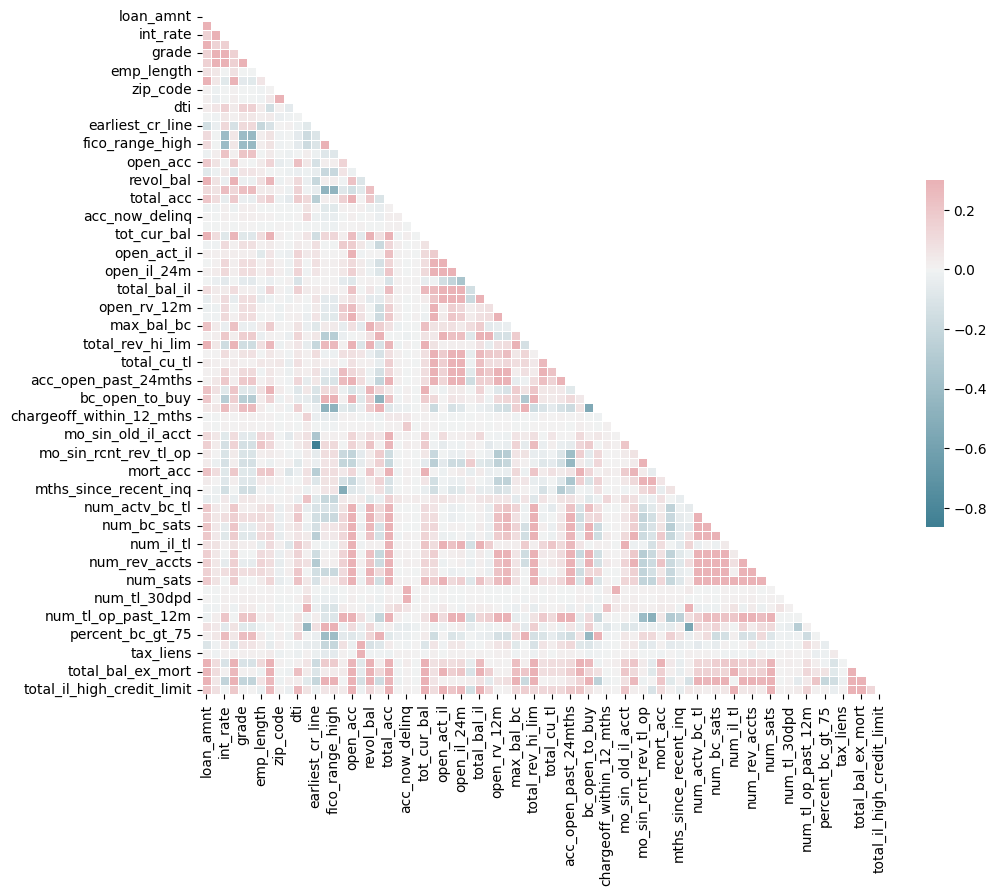

Removed columns:
	bc_open_to_buy
	bc_util
	fico_range_low
	grade
	int_rate
	loan_amnt
	num_actv_bc_tl
	num_actv_rev_tl
	num_bc_tl
	num_op_rev_tl
	open_acc
	revol_bal
	revol_util
	tot_cur_bal
	total_bal_ex_mort


In [82]:
from src import algebra, visualize
from src.feature_engineering import drop_corr_pairs

cols = df.columns.values
corr = algebra.correlation_matrix(df.drop(columns=['loan_status']))

# plot correlation matrix
visualize.correlation_matrix(corr)

df = drop_corr_pairs(df, corr)

removed = np.setdiff1d(cols, df.columns.values)
print(f"Removed columns:\n\t{"\n\t".join(sorted(removed))}")

### Scale feature values

In [84]:
from src.preprocessing import scale_features

df = scale_features(df, target='loan_status')

### Take another peak

In [85]:
df.head()

,term,installment,sub_grade,emp_length,annual_inc,loan_status,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_high,inq_last_6mths,pub_rec,total_acc,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_bc_sats,num_il_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bc_limit,total_il_high_credit_limit,application_type_Individual,application_type_Joint App,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified
0,-0.567076,-1.210381,0.357419,1.060627,-0.304324,0,-1.039839,-0.428396,-1.137531,-0.363409,0.587006,-0.664214,0.366098,-0.360064,-1.010729,-0.116445,-0.065531,0.042732,1.703560,-0.158524,-0.423393,-0.265847,0.417794,-0.722090,-2.391756,1.789141,0.330968,-1.042804,-1.623058,-0.641795,2.247770,0.177674,1.428073,-0.219405,0.465377,-0.083181,-0.018902,0.432919,-0.582340,-0.611573,-0.550728,-0.345032,-0.638648,-0.454257,1.163977,-0.936966,-0.752798,-0.703725,-0.509316,-0.854995,-0.025912,-0.053537,-0.172879,0.452567,-2.029981,-1.264589,-0.358821,-0.131444,0.032157,-0.895434,-0.655914,True,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False
1,-0.567076,1.456430,-0.107389,1.060627,-0.164327,0,0.199653,-1.128263,-0.205817,0.773946,0.116968,0.590551,3.560665,-0.360064,1.077749,-0.116445,-0.065531,-0.021522,0.623713,-0.690848,-0.423393,-0.265847,0.293003,-0.257147,0.336586,0.810308,0.330968,0.563361,-1.999032,2.187238,-0.385007,-0.330484,2.582902,-0.219405,-0.220013,-0.083181,-0.018902,-0.266323,0.108318,-0.674065,-0.668398,1.170149,-0.704735,-1.183035,-0.376377,2.841348,-0.333551,1.556368,-0.192732,1.939349,-0.025912,-0.053537,-0.172879,-0.101237,0.367449,-1.046238,-0.358821,-0.131444,0.807390,2.717003,-0.394566,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False
2,1.763433,-0.026122,-0.417261,1.060627,-0.192326,0,0.289332,-0.324975,-0.690492,-0.363409,0.202621,-0.036831,-0.698758,-0.360064,-0.593033,-0.116445,-0.065531,-0.021522,-0.456133,-0.690848,-0.423393,2.393161,0.293003,-0.513394,0.336586,-1.147357,-0.228791,-0.663191,0.707982,-0.512073,1.370178,2.210304,-0.304170,0.417260,1.147518,-0.083181,-0.018902,-0.026583,0.021986,0.075839,0.743642,1.675210,2.566565,0.638911,-0.376377,-0.936966,-0.333551,-0.954846,-0.825901,-1.041284,-0.025912,-0.053537,-0.172879,-1.208845,0.671513,0.153273,-0.358821,-0.131444,0.262320,-0.716926,-0.628591,False,True,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False
4,1.763433,-0.572106,2.216651,-1.092971,0.387724,0,-1.091084,-0.428396,0.648790,0.773946,-0.075400,-0.036831,2.495809,-0.360064,0.827132,-0.116445,-0.065531,-0.021522,0.623713,0.373800,-0.423393,1.506825,-0.018975,1.736070,1.147715,2.767974,2.570002,1.465607,1.685514,0.039933,1.370178,0.177674,0.850659,1.690592,0.899246,-0.083181,-0.018902,0.033352,0.302566,-0.549081,-0.433058,2.180270,-0.63

### Handle data imbalance

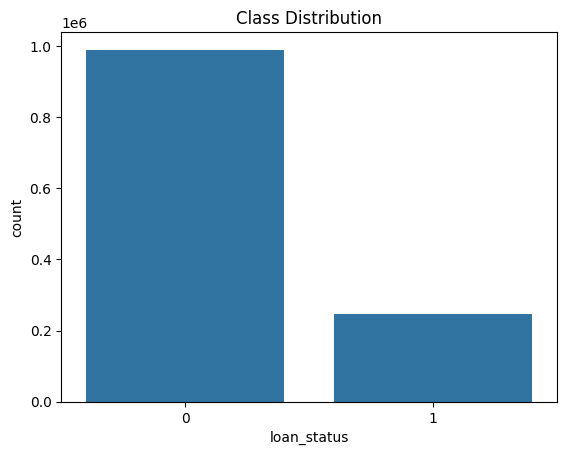

In [86]:
visualize.class_dist(df)

In [87]:
from src import training

X_resampled, y_resampled = training.resample(df)

### Split the data

In [88]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42
)

### Feature Selection using RFE

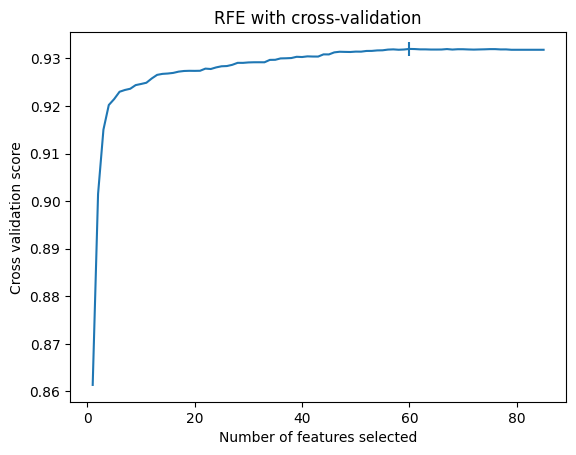

Optimal number of features to select: 60
RFE Test Score: 0.8782224330283932


In [89]:
from src.model import create_model

# Takes ~20min on 16" M2 MBP
if "rfe" not in globals():
    from sklearn.feature_selection import RFECV

    rfe_model = create_model(eval_metric='logloss')

    # Create a model to determine the number of features for feature selection
    rfe = RFECV(
        estimator=rfe_model, cv=FOLDS, scoring='roc_auc', n_jobs=(-1))
    rfe.fit(X_train, y_train)
    n_features_to_select = rfe.n_features_

# Plot the number of features vs. cross-validation scores
visualize.plot_rfe(rfe)

rfe_score = rfe.score(X_test, y_test)
print(f"Optimal number of features to select: {rfe.n_features_}") # type: ignore
print(f"RFE Test Score: {rfe_score}")

In [90]:
cols = X_train.columns[rfe.support_]
removed = X_train.columns[~rfe.support_]
X_train = pd.DataFrame(rfe.transform(X_train), columns=cols) # type: ignore
X_test = pd.DataFrame(rfe.transform(X_test), columns=cols) # type: ignore

print(f"Removed columns:\n\t{"\n\t".join(sorted(removed))}")

Removed columns:
	acc_now_delinq
	avg_cur_bal
	chargeoff_within_12_mths
	collections_12_mths_ex_med
	delinq_amnt
	earliest_cr_line
	home_ownership_ANY
	home_ownership_NONE
	home_ownership_OTHER
	il_util
	mo_sin_old_il_acct
	mths_since_rcnt_il
	num_sats
	num_tl_120dpd_2m
	num_tl_30dpd
	num_tl_90g_dpd_24m
	open_il_12m
	open_rv_12m
	pub_rec
	pub_rec_bankruptcies
	purpose_educational
	purpose_house
	purpose_wedding
	tax_liens
	total_il_high_credit_limit


In [91]:
X_test.head()

,term,installment,sub_grade,emp_length,annual_inc,zip_code,addr_state,dti,delinq_2yrs,fico_range_high,inq_last_6mths,total_acc,tot_coll_amt,open_acc_6m,open_act_il,open_il_24m,total_bal_il,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_bc_sats,num_il_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,tot_hi_cred_lim,total_bc_limit,application_type_Individual,application_type_Joint App,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified
0,-0.567076,-0.223097,-0.107389,0.752970,-0.094328,-0.524185,-0.895864,-0.997085,-0.363409,-0.036831,-0.698758,1.077749,-0.021522,-0.456133,-0.158524,-0.265847,-0.243581,-0.228791,-0.202012,-0.119161,-0.131189,-0.385007,-0.330484,-0.304170,1.053926,-0.938461,-0.299113,0.037622,2.180270,-0.506474,1.732078,-0.376377,-0.593483,0.644692,0.551883,-0.825901,-0.655041,0.671513,-1.264589,0.315813,-0.679345,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,-0.567076,-0.878545,0.667291,-1.708285,-0.234325,1.275801,2.031959,0.417468,-0.363409,-0.036831,1.430953,-0.091799,-0.021522,-0.456133,-0.158524,-0.265847,-0.243581,-0.228791,-0.202012,-0.119161,-0.225030,-0.385007,-0.330484,-0.304170,-0.856071,-0.247802,-0.424097,-0.197718,-0.850092,0.286568,-1.183035,-0.376377,0.436967,-0.752798,0.677443,0.757022,-0.655041,0.671513,0.626838,-0.603334,-0.223680,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-0.567076,0.148180,0.096235,-0.367764,-0.209322,-0.832621,-0.314838,0.112280,-0.363409,0.012457,0.366098,-0.372256,0.013913,0.268918,0.373800,1.798041,0.137199,-0.972464,-0.748212,0.615617,-0.332829,1.081835,-0.330484,2.393186,-0.219405,0.779086,-0.013449,-0.159056,0.325972,0.088308,-0.821255,0.129723,-0.029207,-0.195803,-0.411349,-0.608801,0.270609,-0.325892,-1.264589,-0.668845,-0.493120,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,-0.567076,0.319942,0.667291,0.137657,-0.584514,1.074023,-0.643603,-0.151658,-0.363409,-1.134750,1.430953,-0.676573,-0.013690,0.623713,-0.690848,2.393161,-0.705026,0.890726,-0.461233,1.459930,-0.619715,-0.385007,-0.330484,0.273244,1.053926,0.529189,-0.549081,-0.433058,-0.850092,-0.341257,-0.818646,0.393800,-0.936966,0.225445,-1.080407,-0.509316,-0.101237,-0.018479,0.153273,-0.885302,-0.843761,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,-0.567076,2.184663,0.047547,1.060627,-0.024329,-0.937349,-0.551732,-0.088320,-0.363409,-0.664214,0.366098,-0.258877,-0.021522,-0.456133,-0.158524,-0.265847,-0.243581,-0.228791,-0.202012,-0.119161,-0.053908,-0.385007,-0.330484,-0.304170,-0.856071,0.000403,-0.299113,0.037622,0.665089,-0.506474,-0.089868,0.393800,0.436967,-0.892547,0.300761,-0.192732,-0.655041,0.145248,0.626838,-0.662249,0.401097,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Feature Correlations

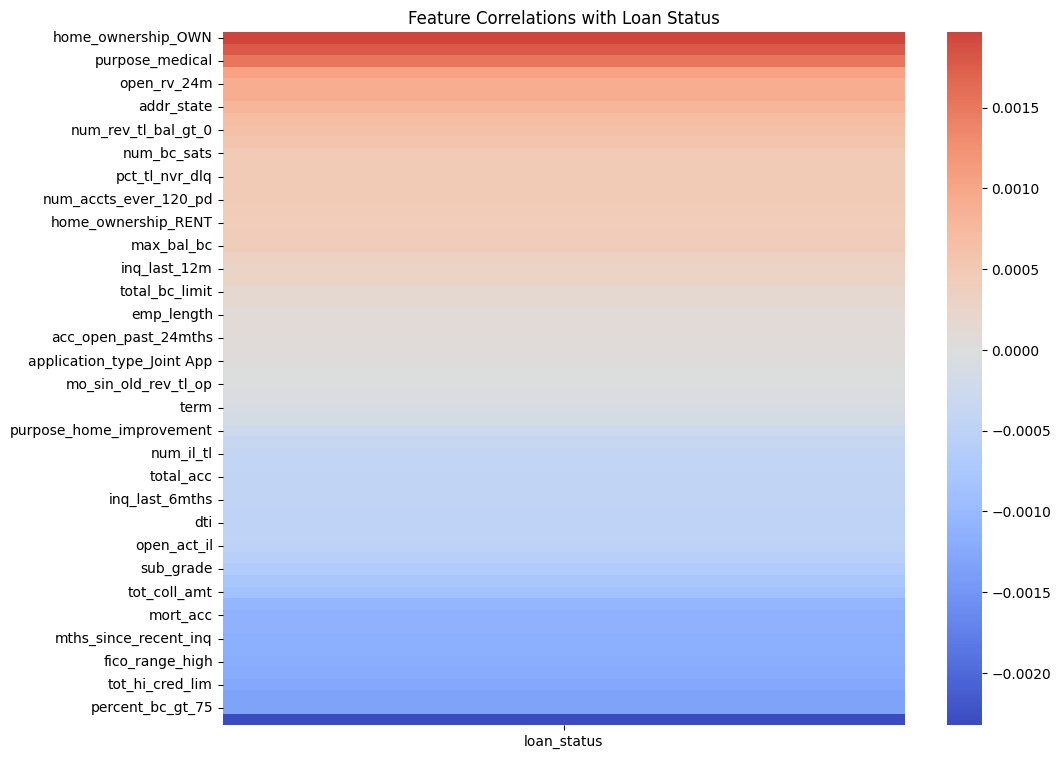

In [92]:
# calculate correlations between the features in X_train and the target variable y_train
df_train = pd.concat([X_train, y_train], axis=1)
correlations = (df_train.corr()['loan_status']
    .sort_values(ascending=False)
    .to_frame()
    .drop('loan_status')
)

visualize.correlations(correlations)

## Write the preprocessed data

In [93]:
import joblib

joblib.dump((X_train, X_test, y_train, y_test), '../data/processed/accepted_2007_to_2018Q4.pkl')

['../data/processed/accepted_2007_to_2018Q4.pkl']